# Import dependencies and determine working directory

In [2]:
# Import libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
# get current directory
dir = os.path.dirname(os.path.abspath('__file__'))

In [4]:
# get image path
imagePath = os.path.join(dir,'..','01_raw_data', 'CelebA', 'Img', 'img_celeba.7z', 'img_celeba', '000001.jpg')

In [5]:
# load face cascade classifier https://github.com/opencv/opencv/tree/master/data/haarcascades
cascade_path = os.path.join(dir,'..','02_pretrained_models', 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cascade_path)

In [6]:
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
# Read the image
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [8]:
# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=5
)

In [9]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

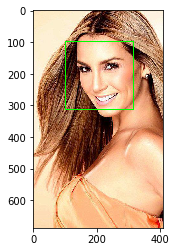

In [10]:
plt.imshow(convertToRGB(image))
plt.show()